<a href="https://colab.research.google.com/github/ramsoi53/ramsoi/blob/main/NLP_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data : U.S. Patent Phrase to Phrase Matching**

# Step1 : Get Data from Kaggle

In [1]:
#코드가 캐글내에서 구동되고 있는지를 확인하는

import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    print("This code is running in a Kaggle kernel.")
else:
    print("This code is running outside of Kaggle.")

This code is running outside of Kaggle.


In [2]:
#Kaggle API 활용하기 -> 캐글의 데이터 활용하기 위해

!pip install kaggle


In [3]:
creds = '{"username":"ramsoi","key":"1645ab4b76e59d6ad3f415b028af9e78"}' #Kaggle 내 profile에서 받은 api key

In [4]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
path = Path('us-patent-phrase-to-phrase-matching')

In [6]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [7]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

In [8]:
!ls {path}

sample_submission.csv  test.csv  train.csv


# **#Read Data and EDA**

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv(path/'train.csv')

In [11]:
df = pd.DataFrame(df)

In [12]:
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [13]:
df.info() #결측값은 없고, 데이터타입이 4개는 object이고 나머지 하나는 float네.. encoding을 해야할듯. 총 5개의 컬럼 즉 features에 36473개의 각각 값들이 존재한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


In [14]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [15]:
df.anchor.value_counts()

anchor
component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: count, Length: 733, dtype: int64

In [16]:
df['input'] = 'TEXT1:' + df['context'] + '; TEXT2:' + df['target'] + '; ANC1:' + df['anchor'] # 이렇게 통합된 input을 넣는게 모델에겐 더 효율적이라고 하네..

In [17]:
df.input.head()

0    TEXT1:A47; TEXT2:abatement of pollution; ANC1:...
1      TEXT1:A47; TEXT2:act of abating; ANC1:abatement
2     TEXT1:A47; TEXT2:active catalyst; ANC1:abatement
3    TEXT1:A47; TEXT2:eliminating process; ANC1:aba...
4       TEXT1:A47; TEXT2:forest region; ANC1:abatement
Name: input, dtype: object

# Tokenization

In [18]:
!pip install datasets
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

In [19]:
ds.info

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value(dtype='string', id=None), 'anchor': Value(dtype='string', id=None), 'target': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'score': Value(dtype='float64', id=None), 'input': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [20]:
ds[:5]

{'id': ['37d61fd2272659b1',
  '7b9652b17b68b7a4',
  '36d72442aefd8232',
  '5296b0c19e1ce60e',
  '54c1e3b9184cb5b6'],
 'anchor': ['abatement', 'abatement', 'abatement', 'abatement', 'abatement'],
 'target': ['abatement of pollution',
  'act of abating',
  'active catalyst',
  'eliminating process',
  'forest region'],
 'context': ['A47', 'A47', 'A47', 'A47', 'A47'],
 'score': [0.5, 0.75, 0.25, 0.5, 0.0],
 'input': ['TEXT1:A47; TEXT2:abatement of pollution; ANC1:abatement',
  'TEXT1:A47; TEXT2:act of abating; ANC1:abatement',
  'TEXT1:A47; TEXT2:active catalyst; ANC1:abatement',
  'TEXT1:A47; TEXT2:eliminating process; ANC1:abatement',
  'TEXT1:A47; TEXT2:forest region; ANC1:abatement']}

In [21]:
#허킹페이스의 DATASET라이브러니는 NLP작업에서 데이터셋을 효율적으로 처리하는데 탁월함. 이렇게 판다스 데이터를 변환한후
#TOKENIZATION을 통해 토큰별로 쪼개고 그 후 이를 NUMERICALIZATION을 통해 숫자화해서 모델에 넣어줘야함

In [22]:
#MODEL SELECTION

model_nm = 'microsoft/deberta-v3-small'

In [23]:
#AutoToeknizer는 모델에 알맞는 토크나이저를 알아서 찾아준다.
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.


In [24]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [25]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [26]:
def tok_func(x): return tokz(x['input'])

In [27]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [28]:
row=tok_ds[0]
row['input'], row['input_ids']

('TEXT1:A47; TEXT2:abatement of pollution; ANC1:abatement',
 [1,
  54453,
  435,
  294,
  558,
  5753,
  346,
  54453,
  445,
  294,
  16191,
  297,
  17019,
  265,
  6435,
  346,
  23702,
  435,
  294,
  16191,
  297,
  17019,
  2])

In [29]:
tokz.vocab['▁he']

313

In [30]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

# **Test and Validation sets**

In [31]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


# **Validation set**

In [32]:
def f(x): return -3*x**2 + 2*x + 20

In [33]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='b'):
    x=np.linspace(min, max, 100)[:,None] #[:,None] 이건 1차원을 2차원으로 바꿔주는거라는데.. 솔직히 안해도 결과값은 차이가 없는것 같은데..
    plt.plot(x, f(x), color)

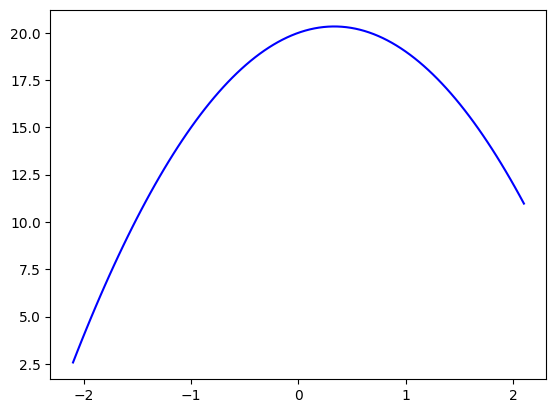

In [34]:
plot_function(f)

In [35]:
from numpy.random import normal, seed, uniform
np.random.seed(42)

In [36]:
#Add Noise

def noise(x,scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add):return x*(1+noise(x,mult)) + noise(x,add)

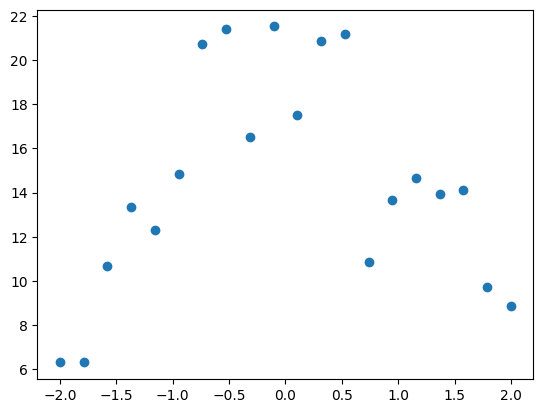

In [37]:
x = np.linspace(-2,2, num=20)[:,None]
y = add_noise(f(x), 0.2,1.3)
plt.scatter(x,y)

In [38]:
#오버피팅/언더피팅 판별 함수
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)



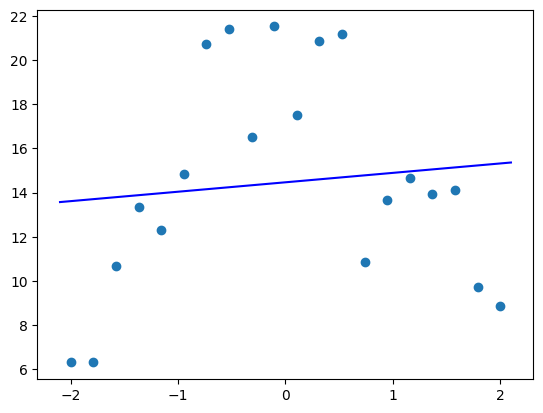

In [39]:
plot_poly(1) #Underfit

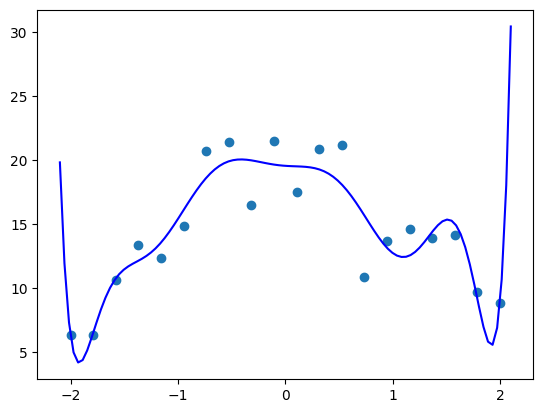

In [40]:
plot_poly(10)

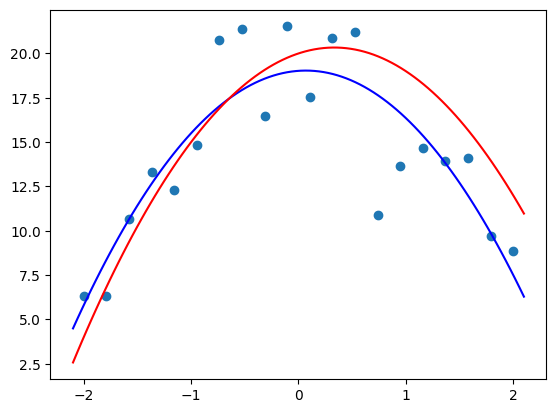

In [41]:
plot_poly(2)
plot_function(f, color='r')

In [42]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [43]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func,batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

# **Metrics and Correlation**

In [44]:
# 데이터 forbidden error로 아래 코드로 직접 대운로드
# # from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing(as_frame=True)
# housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
# housing.head()

In [45]:
# 데이터 파일 URL
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"

# 칼럼 이름 지정
columns = [
    "MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude", "MedianHouseValue"
]

# 데이터 읽기
housing = pd.read_csv(data_url, delim_whitespace=True, names=columns)

# 데이터 샘플 확인
print(housing.head())

                           MedInc  HouseAge  AveRooms  AveBedrms  Population  \
0.00632 18.0 2.31 0 0.538   6.575      65.2    4.0900          1       296.0   
0.02731 0.0  7.07 0 0.469   6.421      78.9    4.9671          2       242.0   
0.02729 0.0  7.07 0 0.469   7.185      61.1    4.9671          2       242.0   
0.03237 0.0  2.18 0 0.458   6.998      45.8    6.0622          3       222.0   
0.06905 0.0  2.18 0 0.458   7.147      54.2    6.0622          3       222.0   

                           AveOccup  Latitude  Longitude  MedianHouseValue  
0.00632 18.0 2.31 0 0.538      15.3    396.90       4.98              24.0  
0.02731 0.0  7.07 0 0.469      17.8    396.90       9.14              21.6  
0.02729 0.0  7.07 0 0.469      17.8    392.83       4.03              34.7  
0.03237 0.0  2.18 0 0.458      18.7    394.63       2.94              33.4  
0.06905 0.0  2.18 0 0.458      18.7    396.90       5.33              36.2  


In [46]:
# np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.        , -0.24026493,  0.20524621, -0.20984667, -0.29204783,
        -0.35550149,  0.12806864, -0.61380827,  0.69535995],
       [-0.24026493,  1.        , -0.74788054,  0.45602245,  0.50645559,
         0.26151501, -0.27353398,  0.60233853, -0.37695457],
       [ 0.20524621, -0.74788054,  1.        , -0.49458793, -0.53443158,
        -0.23247054,  0.29151167, -0.49699583,  0.24992873],
       [-0.20984667,  0.45602245, -0.49458793,  1.        ,  0.91022819,
         0.46474118, -0.44441282,  0.48867633, -0.38162623],
       [-0.29204783,  0.50645559, -0.53443158,  0.91022819,  1.        ,
         0.46085304, -0.44180801,  0.54399341, -0.46853593],
       [-0.35550149,  0.26151501, -0.23247054,  0.46474118,  0.46085304,
         1.        , -0.1773833 ,  0.37404432, -0.50778669],
       [ 0.12806864, -0.27353398,  0.29151167, -0.44441282, -0.44180801,
        -0.1773833 ,  1.        , -0.3660869 ,  0.33346082],
       [-0.61380827,  0.60233853, -0.49699583,  0.48867633,  0

In [47]:
np.corrcoef(housing.MedInc, housing.MedianHouseValue)

array([[1.        , 0.69535995],
       [0.69535995, 1.        ]])

In [48]:
def corr(x,y): return np.corrcoef(x,y)[0][1] #0,1은 상관계수가 위처럼 행렬로 반환되는데 여기서 행렬의 특정값만을 선택. 그래야지 아래 그래프가 np array에 넘어가서 오류없이 나
corr(housing.MedInc, housing.MedianHouseValue)

0.6953599470715393

In [49]:
def show_corr(df, a, b):
    x,y=df[a],df[b]
    plt.scatter(x,y,alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r:{corr(x,y):.2f}')

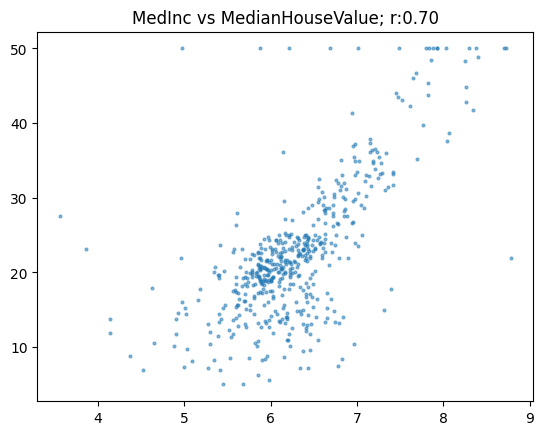

In [50]:
show_corr(housing, 'MedInc', 'MedianHouseValue')

In [51]:
housing.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedianHouseValue'],
      dtype='object')

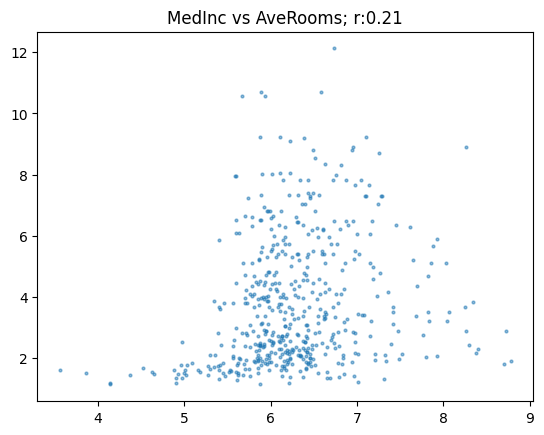

In [52]:
show_corr(housing, 'MedInc','AveRooms')

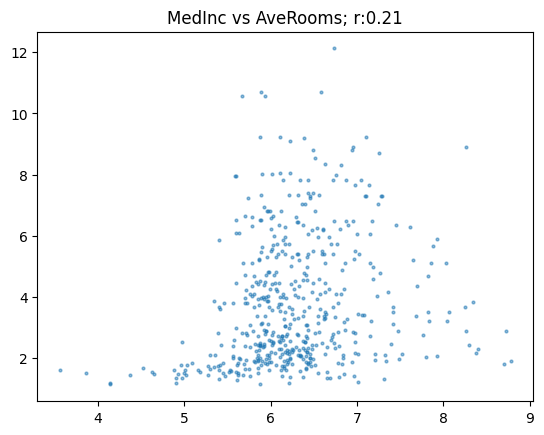

In [53]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

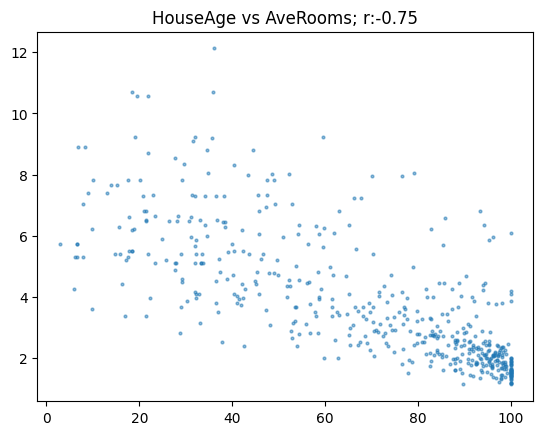

In [54]:
show_corr(subset,'HouseAge', 'AveRooms')

In [55]:
def corr_d(eval_pred) : return{'person':corr(*eval_pred)}

# Traning Model

In [56]:
!pip install accelerate -U
from transformers import TrainingArguments,Trainer

In [57]:
bs = 128
epochs = 4

In [58]:
lr = 8e-5
!pip install transformers[torch] -U

In [60]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine',
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [61]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm,num_labels=1)
trainer = Trainer(model,args,train_dataset=dds['train'], eval_dataset=dds['test'],tokenizer=tokz,compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
trainer.train();

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 